<a href="https://colab.research.google.com/github/Doutrespace/SoundscapeNET/blob/main/SoundscapeNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with YAMNet for Environmental Sound Classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network developed by Google that can classify audio events into [521 different classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), including everyday sounds such as laughter, barking, or a siren. Originally trained on a large corpus of diverse audio data from YouTube, YAMNet is capable of robustly recognizing a wide array of sound events.

In this tutorial, you will learn how to:

1. **Load and use the YAMNet model for inference:** You'll start by loading the pre-trained YAMNet model and using it to predict the classes of sounds in audio clips.

2. **Build a new model using YAMNet embeddings:** We'll use YAMNet as a feature extractor to create embeddings from your audio data. These embeddings will serve as the input for a new model that you will build and train to classify specific sounds such as cat and dog sounds.

3. **Evaluate and export your model:** After training, you'll evaluate the performance of your new model on a test dataset and learn how to save and export the model for later use.

This hands-on approach will provide you with practical experience and a solid foundation in applying deep learning techniques for environmental sound classification using transfer learning.


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [20]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"
#!pip install -U tensorflow-io
#!pip uninstall -y tensorflow tensorflow-io  # Uninstall both libraries
#!pip install tensorflow==2.15.0             # Install the specific TensorFlow version
#!pip install tensorflow-io                  # Install the latest compatible TensorFlow I/O



In [21]:
from google.colab import drive
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory containing your audio files
audio_folder = '/content/drive/MyDrive/SoundscapesWuerzburg'

# List all WAV files in the directory, accommodating both lowercase and uppercase extensions
audio_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.lower().endswith('.wav')]
print(f"Found {len(audio_files)} WAV files.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 90 WAV files.


In [22]:
# Utility function to load and resample a WAV file
def load_wav_16k_mono(filename):
    """Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio."""
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    if sample_rate != 16000:
        wav = tfio.audio.resample(wav, rate_in=tf.cast(sample_rate, tf.int64), rate_out=16000)
    return wav

# Function to process and display a single audio file
def process_and_display_audio(file_path):
    """Process a single WAV file and plot its waveform."""
    wav_data = load_wav_16k_mono(file_path)
    plt.figure(figsize=(10, 4))
    plt.plot(wav_data.numpy())
    plt.title(f"Waveform of Audio File: {os.path.basename(file_path)}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(wav_data, rate=16000))

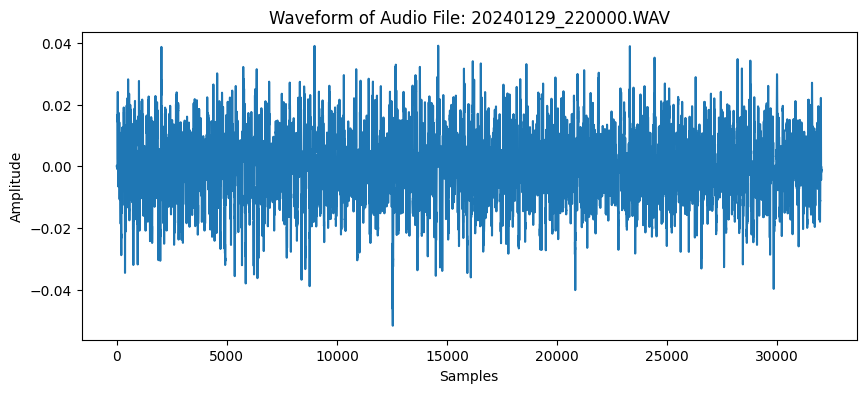

In [26]:
# Process the first WAV file in the directory to demonstrate
if audio_files:
    process_and_display_audio(audio_files[48])  # Process the first audio file
else:
    print("No WAV files found in the directory.")

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [29]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.

In [32]:
# Assuming yamnet_model is already loaded and available for inference
def perform_inference(file_path):
    # Load and process the audio data
    wav_data = load_wav_16k_mono(file_path)

    # Run the YAMNet model
    scores, embeddings, spectrogram = yamnet_model(wav_data)

    # Average the scores and find the class with the highest mean score
    class_scores = tf.reduce_mean(scores, axis=0)
    top_class = tf.math.argmax(class_scores)
    inferred_class = class_names[top_class.numpy()]

    # Print the inference results
    print(f'The main sound is: {inferred_class}')
    print(f'The embeddings shape: {embeddings.shape}')

# Example file path from Google Drive
audio_file_path = '/content/drive/MyDrive/SoundscapesWuerzburg/20240130_024500.WAV'
perform_inference(audio_file_path)


The main sound is: Rustle
The embeddings shape: (4, 1024)


## The ESC-50
 dataset (Piczak, 2015) is a labeled collection of 2,000 five-second long environmental audio recordings. The dataset consists of 50 classes, with 40 examples per class.

Download the dataset and extract it.

In [34]:
import os
import tensorflow as tf

# Path to save the dataset on Google Drive
drive_path = '/content/drive/My Drive/ESC-50'

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Download and extract the dataset
dataset_path = tf.keras.utils.get_file(
    'esc-50.zip',
    'https://github.com/karoldvl/ESC-50/archive/master.zip',
    cache_dir=drive_path,
    cache_subdir='',
    extract=True
)

# The extraction path will contain the folder structure from the zip
base_data_path = os.path.join(drive_path, 'ESC-50-master/audio/')
esc50_csv = os.path.join(drive_path, 'ESC-50-master/meta/esc50.csv')

pd_data = pd.read_csv(esc50_csv)
pd_data.head()


   8192/Unknown - 0s 0us/step

In [35]:
pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [36]:
category_to_group = {
    'dog': 'Animals',
    'rooster': 'Animals',
    'pig': 'Animals',
    'cow': 'Animals',
    'frog': 'Animals',
    'cat': 'Animals',
    'hen': 'Animals',
    'insects': 'Animals',  # flying insects
    'sheep': 'Animals',
    'crow': 'Animals',
    'rain': 'Natural soundscapes & water sounds',
    'sea_waves': 'Natural soundscapes & water sounds',
    'crackling_fire': 'Natural soundscapes & water sounds',
    'crickets': 'Natural soundscapes & water sounds',
    'chirping_birds': 'Natural soundscapes & water sounds',
    'water_drops': 'Natural soundscapes & water sounds',
    'wind': 'Natural soundscapes & water sounds',
    'pouring_water': 'Natural soundscapes & water sounds',
    'toilet_flush': 'Natural soundscapes & water sounds',
    'thunderstorm': 'Natural soundscapes & water sounds',
    'crying_baby': 'Human, non-speech sounds',
    'sneezing': 'Human, non-speech sounds',
    'clapping': 'Human, non-speech sounds',
    'breathing': 'Human, non-speech sounds',
    'coughing': 'Human, non-speech sounds',
    'footsteps': 'Human, non-speech sounds',
    'laughing': 'Human, non-speech sounds',
    'brushing_teeth': 'Human, non-speech sounds',
    'snoring': 'Human, non-speech sounds',
    'drinking_sipping': 'Human, non-speech sounds',
    'door_knock': 'Interior/domestic sounds',
    'mouse_click': 'Interior/domestic sounds',
    'keyboard_typing': 'Interior/domestic sounds',
    'door_wood_creaks': 'Interior/domestic sounds',
    'can_opening': 'Interior/domestic sounds',
    'washing_machine': 'Interior/domestic sounds',
    'vacuum_cleaner': 'Interior/domestic sounds',
    'clock_alarm': 'Interior/domestic sounds',
    'clock_tick': 'Interior/domestic sounds',
    'glass_breaking': 'Interior/domestic sounds',
    'helicopter': 'Exterior/urban noises',
    'chainsaw': 'Exterior/urban noises',
    'siren': 'Exterior/urban noises',
    'car_horn': 'Exterior/urban noises',
    'engine': 'Exterior/urban noises',
    'train': 'Exterior/urban noises',
    'church_bells': 'Exterior/urban noises',
    'airplane': 'Exterior/urban noises',
    'fireworks': 'Exterior/urban noises',
    'hand_saw': 'Exterior/urban noises'
}


In [ ]:
# Define the classes of interest by their presence columns
classes_of_interest = ['1_engine_presence', '2_machinery-impact_presence',
                       '3_non-machinery-impact_presence', '4_powered-saw_presence',
                       '5_alert-signal_presence', '6_music_presence',
                       '7_human-voice_presence', '8_dog_presence']



In [ ]:
# Filter DataFrame to include rows where any specified class presence is 1
filtered_pd = pd_data[(pd_data[classes_of_interest] == 1).any(axis=1)]

# Map presence columns to new IDs if necessary
map_class_to_id = {name: idx for idx, name in enumerate(classes_of_interest, start=0)}

# Create a new target column based on the first matching class of interest
filtered_pd['target'] = (filtered_pd[classes_of_interest] == 1).idxmax(axis=1)
filtered_pd['target'] = filtered_pd['target'].apply(lambda name: map_class_to_id[name])

# Update the filename column to contain the full path to each audio file
filtered_pd['filename'] = filtered_pd['audio_filename'].apply(lambda x: os.path.join(base_audio_path, x))

# Display the first 10 rows of the filtered DataFrame
filtered_pd.head(10)

<ipython-input-11-4d3fda75c57a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd['target'] = (filtered_pd[classes_of_interest] == 1).idxmax(axis=1)
<ipython-input-11-4d3fda75c57a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd['target'] = filtered_pd['target'].apply(lambda name: map_class_to_id[name])
<ipython-input-11-4d3fda75c57a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence,target,filename
0,validate,0,00_000066.wav,95,1,547,40.729508,-73.993881,2017,28,...,1,1,1,1,1,1,1,1,0,/content/SONYC-UST/data/audio/00_000066.wav
1,validate,0,00_000066.wav,108,1,547,40.729508,-73.993881,2017,28,...,1,0,0,0,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000066.wav
2,validate,0,00_000066.wav,127,1,547,40.729508,-73.993881,2017,28,...,1,0,0,0,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000066.wav
3,validate,0,00_000071.wav,64,1,547,40.729508,-73.993881,2016,50,...,1,0,0,0,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000071.wav
4,validate,0,00_000071.wav,66,1,547,40.729508,-73.993881,2016,50,...,0,0,0,1,0,0,0,0,3,/content/SONYC-UST/data/audio/00_000071.wav
5,validate,0,00_000071.wav,133,1,547,40.729508,-73.993881,2016,50,...,0,1,0,0,0,0,0,0,1,/content/SONYC-UST/data/audio/00_000071.wav
7,validate,0,00_000085.wav,133,1,547,40.729508,-73.993881,2017,3,...,0,1,0,0,0,0,0,0,1,/content/SONYC-UST/data/audio/00_000085.wav
8,validate,0,00_000085.wav,152,1,547,40.729508,-73.993881,2017,3,...,1,0,0,1,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000085.wav
9,validate,0,00_000118.wav,45,1,547,40.729508,-73.993881,2017,40,...,0,0,0,0,0,0,1,0,6,/content/SONYC-UST/data/audio/00_000118.wav
10,validate,0,00_000118.wav,58,1,547,40.729508,-73.993881,2017,40,...,1,0,0,0,0,0,1,0,0,/content/SONYC-UST/data/audio/00_000118.wav


In [ ]:
# Print the column names of the DataFrame
print(filtered_pd.columns)

Index(['split', 'sensor_id', 'audio_filename', 'annotator_id', 'borough',
       'block', 'latitude', 'longitude', 'year', 'week', 'day', 'hour',
       '1-1_small-sounding-engine_presence',
       '1-2_medium-sounding-engine_presence',
       '1-3_large-sounding-engine_presence',
       '1-X_engine-of-uncertain-size_presence', '2-1_rock-drill_presence',
       '2-2_jackhammer_presence', '2-3_hoe-ram_presence',
       '2-4_pile-driver_presence',
       '2-X_other-unknown-impact-machinery_presence',
       '3-1_non-machinery-impact_presence', '4-1_chainsaw_presence',
       '4-2_small-medium-rotating-saw_presence',
       '4-3_large-rotating-saw_presence',
       '4-X_other-unknown-powered-saw_presence', '5-1_car-horn_presence',
       '5-2_car-alarm_presence', '5-3_siren_presence',
       '5-4_reverse-beeper_presence',
       '5-X_other-unknown-alert-signal_presence',
       '6-1_stationary-music_presence', '6-2_mobile-music_presence',
       '6-3_ice-cream-truck_presence',
       '6-X

### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [ ]:
import tensorflow as tf

# Ensure 'filename' is treated as string
filenames = filtered_pd['filename'].astype(str).values
targets = filtered_pd['target'].values
splits = filtered_pd['split'].values

# Create the TensorFlow dataset
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, splits))

In [ ]:
def load_wav_for_map(filename, target, split):
  return load_wav_16k_mono(filename), target, split

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, target, split):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(target, num_embeddings),
            tf.repeat(split, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [ ]:
import tensorflow as tf
import tensorflow.python.data.ops.dataset_ops as dataset_ops

print("TensorFlow file:", tf.__file__)
print("Dataset_ops file:", dataset_ops.__file__)



TensorFlow file: /usr/local/lib/python3.10/dist-packages/tensorflow/__init__.py
Dataset_ops file: /usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/dataset_ops.py


### Split the data

You will use the `split` column to split the dataset into train, validation and test sets.

SONYC is arranged into five uniformly-sized cross-validation `split`s, such that clips from the same original source are always in the same `split` - find out more in the  paper.

The last step is to remove the `split` column from the dataset since you're not going to use it during training.

In [ ]:
import tensorflow as tf

# Cache the entire dataset to improve performance
cached_ds = main_ds.cache()

# Filter datasets based on the 'split' column value using string comparison
train_ds = cached_ds.filter(lambda embedding, target, split: tf.equal(split, 'train'))
val_ds = cached_ds.filter(lambda embedding, target, split: tf.equal(split, 'validate'))
test_ds = cached_ds.filter(lambda embedding, target, split: tf.equal(split, 'test'))

# Define a function to remove the 'split' column now that it's not needed anymore
def remove_split_column(embedding, target, split):
    return embedding, target

# Apply the function to remove the 'split' column from each dataset
train_ds = train_ds.map(remove_split_column)
val_ds = val_ds.map(remove_split_column)
test_ds = test_ds.map(remove_split_column)

# Final dataset preparation for training, validation, and testing
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


## Create my model

In [ ]:
import tensorflow as tf

# Define the number of classes you have
num_classes = 8  # Update this if the number of classes changes

# Create the model using the TensorFlow Keras API
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),  # Ensure the input shape matches the output shape of YAMNet embeddings
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)  # Output layer with a node for each class
], name='my_model')


In [ ]:
# Display the model's architecture
my_model.summary()

# Compile the model with the specified loss function, optimizer, and metrics
my_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 528,904
Trainable params: 528,904
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Set up early stopping to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Ensure you have a GPU enabled
import tensorflow as tf

# Check if GPU is available and identify the GPU type
gpu = tf.config.experimental.list_physical_devices('GPU')
if gpu:
    print('GPU is available:', tf.test.gpu_device_name(), '\nGPU details:', gpu)
else:
    print('GPU not available, consider changing the runtime type to GPU.')

import time

# Training the model
start_time = time.time()
history = my_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[callback]
)
end_time = time.time()

# Calculate and print the training time
total_training_time = end_time - start_time
print(f"Total training time for 20 epochs: {total_training_time / 60:.2f} minutes")


GPU not available, consider changing the runtime type to GPU.
Epoch 1/10
19377/19377 [==============================] - 1679s 84ms/step - loss: 1.1106 - accuracy: 0.6036 - val_loss: 1.3215 - val_accuracy: 0.5563
Epoch 2/10
19377/19377 [==============================] - 68s 4ms/step - loss: 1.1170 - accuracy: 0.6031 - val_loss: 1.3404 - val_accuracy: 0.5489
Epoch 3/10
19377/19377 [==============================] - 68s 3ms/step - loss: 1.1200 - accuracy: 0.6027 - val_loss: 1.3348 - val_accuracy: 0.5532
Epoch 4/10
19377/19377 [==============================] - 68s 3ms/step - loss: 1.1165 - accuracy: 0.6038 - val_loss: 1.3426 - val_accuracy: 0.5541
Total training time for 20 epochs: 31.38 minutes


In [ ]:
# Evaluate the model on the test dataset to determine its final accuracy
loss, accuracy = my_model.evaluate(test_ds)
# Print out the loss and accuracy
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Plot the model

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assume predictions and true_labels are available from your model's evaluation
conf_mat = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

# Assuming 'embeddings' are extracted from the YAMNet model
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 5))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Embedding Space')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve from y_test and preds
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plotting waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.numpy())
plt.title('Waveform of Audio Sample')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# If you have spectrogram data available
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower')
plt.title('Spectrogram of Audio Sample')
plt.xlabel('Time Frame')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


Test your model
Next, try your model on the embedding from the previous test using YAMNet only.